In [65]:
%reload_ext autoreload
%autoreload 2
from dataset import IEEE_CIS
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [66]:
dm = IEEE_CIS()
energy_data = dm.load_energy_data()
# Change this if you want to see different dataset
# Only work on Solar dataset since Building ones have NaN, and I don't know how to deal with them
name = 'Solar4'

In [67]:
split_idx = len(energy_data[name][:dm.PHASE1_TIME]) - 1
start_time = energy_data[name].index[0]
end_time = energy_data[name].index[-1]
print(split_idx, start_time, end_time)

46408 2019-06-05 14:00:00 2020-11-30 23:45:00


In [68]:
### Load weather data
weather_data = dm.load_ERA5_weather_data()
weather_data = weather_data.drop(['coordinates (lat,lon)', 'model (name)', 'utc_offset (hrs)', 'model elevation (surface)'], axis=1)
weather_data = weather_data.resample("15min").asfreq()
weather_data = weather_data.fillna(method='ffill')

In [69]:
day = 24*60*60
year = (365.2425)*day

solar0 = energy_data[name]
# Normalize value
solar0 = (solar0-solar0.min())/(solar0.max()-solar0.min())
# Saved max and min for denormalize later
y_norm_val = [solar0['energy'].max(), solar0['energy'].min()]

solar0 = solar0.join(weather_data)
# Transform timestamp into seconds
time_stamp = solar0.index.map(pd.Timestamp.timestamp)
# Transform raw seconds into sin and cos value, creating a seasonal value that represent the repeat of day and year
solar0['day_sin'] = np.sin(time_stamp * (2 * np.pi/day))
solar0['day_cos'] = np.cos(time_stamp * (2 * np.pi/day))
solar0['year_sin'] = np.sin(time_stamp * (2 * np.pi/year))
solar0['year_cos'] = np.cos(time_stamp * (2 * np.pi/year))

# Stack all of the day and year
X_train = np.array(solar0[:split_idx].drop(['energy'], axis=1))
X_test = np.array(solar0[split_idx:].drop(['energy'], axis=1))


# Stack the day and year with weather data
y_train = np.array(solar0['energy'][:split_idx])
y_true = np.array(solar0['energy'][split_idx:])

# Remove trash data (bunchs of 0s) does make the model better
#X_train = X_train[2460:]
#y_train = y_train[2460:]

In [70]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_true.shape)

(46408, 12) (5856, 12)
(46408,) (5856,)


In [71]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tinygrid.utils import mase, denormalize

model = linear_model.Lasso(alpha=0.1)

def fit_and_pred(model, X_train, X_test, y_train, y_true, y_norm_val):
  print("Data", name)
  print(f"Model {model}\n")

  # Fit
  model.fit(X_train, y_train)
  r_sq = model.score(X_train, y_train)
  print(f"coefficient of determination: {r_sq}")
  print(f"intercept: {model.intercept_}")
  print(f"slope: {model.coef_}\n")

  # Generate prediction
  y_pred = model.predict(X_test)
  # Denormalize value back to original
  y_true  = denormalize(y_true, y_norm_val[0], y_norm_val[1])
  y_pred  = denormalize(y_pred, y_norm_val[0], y_norm_val[1])
  y_train = denormalize(y_train, y_norm_val[0], y_norm_val[1])
  print(f"predicted response:\n{y_pred}")
  print("mean square error:", mean_squared_error(y_true, y_pred))
  print("mean abs error:", mean_absolute_error(y_true, y_pred))
  print("mean absolute scale error", mase(y_pred, y_true, y_train))

  # Plot
  ll = range(y_true.shape[0])
  plt.figure(figsize=(10, 8), dpi=80)
  plt.plot(ll, y_true)
  plt.plot(ll, y_pred)

Data Solar4
Model Lasso(alpha=0.1)

coefficient of determination: 0.6369995046879826
intercept: -0.7217824282397011
slope: [-0.00000000e+00  0.00000000e+00 -0.00000000e+00  6.76150080e-06
  0.00000000e+00  7.53642489e-04  1.55441937e-04  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]

predicted response:
[0.43188266 0.43188266 0.43188266 ... 0.1931066  0.1931066  0.1931066 ]
mean square error: 0.022236836613518503
mean abs error: 0.09652492923124896
mean absolute scale error 1.0308650092997265


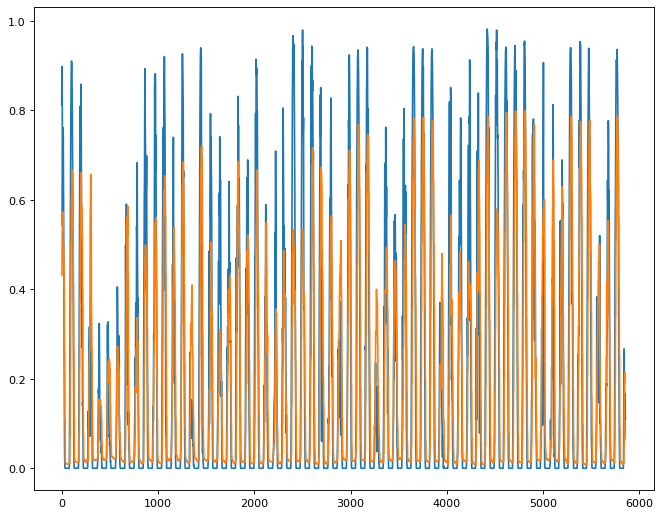

In [72]:
fit_and_pred(model, X_train, X_test, y_train, y_true, y_norm_val)